# Sequence Final Project - Optimization

## First Approach to the Optimization Problem

### Requirements

In [41]:
from library import init_params
from pyomo.environ import *
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
import math

### Parameters

In [ ]:
# Décommenter la ligne que vous voulez utiliser pour l'instance
# instance = "instances/toy_instance.json"
instance = "instances/medium_instance.json" 
# instance = "instances/large_instance.json"
h,qualif_nb,staff_nb,project_nb,C,CA,N,G,D,R,names = init_params(instance)

In [47]:
print(G)

[[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1]]


## Solving function minimising the number of project

We consider a new model in which the firm knows the optimal profit it can reach but is still willing to lose a certain part of this profit in order to improve other objectives. The first other objective will be to minimise the number of project on which each staff member will work during the period in order to ensure maximum expertise of the employees in each project and better work confort.

***NEW SOLVING FUNCTION***

In [43]:
def solv_min_proj(epsilon,h,staff_nb,qualif_nb,project_nb,CA,N,C,G):

    # --- 1. Model creation

    model = ConcreteModel()
    # Sets
    model.H = RangeSet(0,h-1)          # Planning Horizon
    model.S = RangeSet(0,staff_nb-1)        # Staff set
    model.P = RangeSet(0,project_nb-1)          # Projects set
    model.Q= RangeSet(0,qualif_nb-1)           # Qualifications set
        
    # Params
    
    model.h = Param(initialize=h)
    model.staff_nb = Param(initialize=staff_nb)
    model.qualif_nb = Param(initialize=qualif_nb)
    model.project_nb = Param(initialize=project_nb)

    # Variables
    
    model.w = Var(model.H, model.P, model.Q, model.S, within=Binary)
    model.y = Var(model.P,within=Binary)
    model.a = Var(model.S, model.P, within=Binary)
    model.z = Var(model.P, within=NonNegativeIntegers,bounds=(0,h)) # Finition date
    model.l = Var(model.P, within=NonNegativeIntegers,bounds=(0,h)) # Delay of each project
    
    # Objective function
    
    def profit(model):
        return sum(model.y[p] * CA[p] - R[p] * model.l[p] for p in model.P)

    model.obj = Objective(rule=profit, sense=maximize)
    
    # Constraints

    ## Constraint on the validation of the projects
    
    def validation_rule(model,p,q):
        return sum(model.w[t,p,q,s] for t in model.H for s in model.S) >= N[p,q] * model.y[p]
    model.validation = Constraint(model.P, model.Q, rule=validation_rule)

    ## Qualification constraint
    def qualification_rule(model,t,p,q,s):
        return  model.w[t, p, q, s] <= C[s, q]
    model.qualification = Constraint(model.H, model.P, model.Q, model.S, rule=qualification_rule)

    ## Day Off constraint
    def day_off_rule(model,t,s):
        return sum(model.w[t,p,q,s] for p in model.P for q in model.Q) <= G[s,t]
    model.day_off = Constraint(model.H, model.S, rule=day_off_rule)
    
    ## Project affectation contraint
    
    def project_affectation_rule(model,s,p):
        return sum(model.w[t,p,q,s] for t in model.H for q in model.Q) <= model.a[s,p]*h*staff_nb
    
    model.project_affectation = Constraint(model.S, model.P, rule=project_affectation_rule)
    
    ## New constraint on the profit
    
    def project_constraint_rule(model,s):
        return sum(model.a[s,p] for p in model.P) <= epsilon
        
    model.project_constraint = Constraint(model.S, rule=project_constraint_rule)
    
    ## Finition date constraint
    
    def finition_date_rule(model,t,p,q,s):
        return model.z[p] >= (t+1) * model.w[t,p,q,s]
    model.finition_date = Constraint(model.H, model.P, model.Q, model.S, rule=finition_date_rule)
    
    # # If not finished the last time worked on it will be h
    def exception_finition_date(model,p):
        return model.z[p] >= (h - 1)* (1-model.y[p])
    model.exception_finition_date = Constraint(model.P, rule=exception_finition_date)
    
    ## Delay definition constraint

    def delay_definition_rule(model,p):
        return model.l[p] >= model.z[p] - D[p]
    model.delay_definition = Constraint(model.P, rule=delay_definition_rule)
    
    # --- 4. Solve
    
    # Nombre de variables
    num_var = len(list(model.component_data_objects(ctype=pyomo.environ.Var)))
    print("Nombre de variables :", num_var)

    # Nombre de paramètres
    num_param = len(list(model.component_data_objects(ctype=pyomo.environ.Param)))
    print("Nombre de paramètres :", num_param)

    # Nombre de contraintes
    num_constraint = len(list(model.component_data_objects(ctype=pyomo.environ.Constraint)))
    print("Nombre de contraintes :", num_constraint)
    
    start = time.time() 
    solver = SolverFactory("gurobi")  # or 'gurobi' if licensed
    results = solver.solve(model, tee=True)
    end = time.time()
    comp = end-start
    
    # -- 8. Transform it into computable forms
   
    w_arr = np.zeros((h,project_nb,qualif_nb,staff_nb))
    for t in range(h):
        for p in range(project_nb):
            for q in range(qualif_nb):
                for s in range(staff_nb):
                     w_arr[t, p, q, s] = value(model.w[t, p, q, s])

    y_arr = np.zeros((project_nb))
    
    for p in range(project_nb):
        y_arr[p] = value(model.y[p])

    return value(model.obj),w_arr,y_arr,comp,num_var,num_param,num_constraint
    

In [44]:
max_profit,w_arr,y_arr,comp,num_var,num_param,num_constraint =solv_min_proj(project_nb,h,staff_nb,qualif_nb,project_nb,CA,N,C,G)


ERROR: Rule failed when generating expression for Constraint day_off with
index (22, 0): IndexError: index 22 is out of bounds for axis 1 with size 22
ERROR: Constructing component 'day_off' from data=None failed:
        IndexError: index 22 is out of bounds for axis 1 with size 22


IndexError: index 22 is out of bounds for axis 1 with size 22

In [ ]:
# Calculate the optimal value without the projet affectation constraint

max_profit,w_arr,y_arr,comp,num_var,num_param,num_constraint =solv_min_proj(project_nb,h,staff_nb,qualif_nb,project_nb,CA,N,C,G)

# Calculating the first value 

epsilon = 1
profit,w_arr,y_arr,comp,num_var,num_param,num_constraint = solv_min_proj(epsilon,h,staff_nb,qualif_nb,project_nb,CA,N,C,G)
eps = [epsilon]
profits = [profit]
while (epsilon <= project_nb-1) and (profit < max_profit):
    epsilon += 1
    print(epsilon)
    profit,w_arr,y_arr,comp,num_var,num_param,num_constraint = solv_min_proj(epsilon,h,staff_nb,qualif_nb,project_nb,CA,N,C,G)
    eps.append(epsilon)
    profits.append(profit)

Nombre de variables : 16620
Nombre de paramètres : 4
Nombre de contraintes : 33370
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmp4w0xtueo.pyomo.lp
Reading time = 0.11 seconds
x1: 33370 rows, 16620 columns, 99244 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 33370 rows, 16620 columns and 99244 nonzeros
Model fingerprint: 0x66ec50b7
Variable types: 0 continuous, 16620 integer (16590 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+00, 7e+01]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -264.0000000
Presolve removed 32930 rows and 15292 columns
Presolve time: 0.11s
Presolved: 440 rows, 1328 columns, 3387 nonzeros
Variable types: 0 continuous, 1328 integer (1

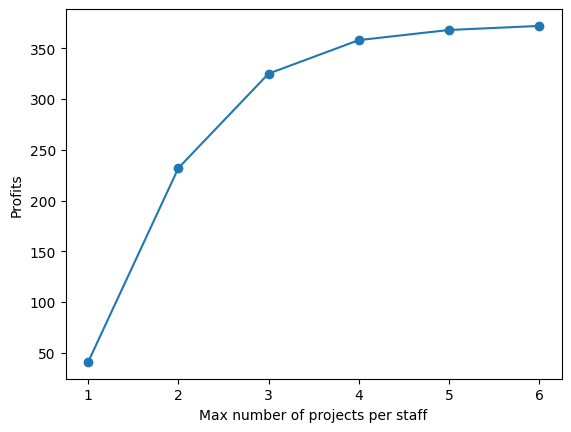

In [ ]:
EPS = np.array(eps)
PROFITS = np.array(profits)

plt.plot(EPS, PROFITS, marker='o')
plt.xlabel('Max number of projects per staff')
plt.ylabel('Profits')
plt.show()

### Finding the optimal project affectation at the biggest profit

In [ ]:
opt_eps = np.where(PROFITS == np.max(PROFITS))[0][0] # We take the smaller number of project affectation per staff that gives the best profit
profit,w_arr,y_arr,comp,num_var,num_param,num_constraint = solv_min_proj(opt_eps,h,staff_nb,qualif_nb,project_nb,CA,N,C,G)

Nombre de variables : 16620
Nombre de paramètres : 4
Nombre de contraintes : 33370
Read LP format model from file /var/folders/z7/f69nzsvj3ng6l90wkyzwbxbm0000gn/T/tmpyj0jds6f.pyomo.lp
Reading time = 0.12 seconds
x1: 33370 rows, 16620 columns, 99244 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 33370 rows, 16620 columns and 99244 nonzeros
Model fingerprint: 0x757a7019
Variable types: 0 continuous, 16620 integer (16590 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+00, 7e+01]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -264.0000000
Presolve removed 32889 rows and 15255 columns
Presolve time: 0.12s
Presolved: 481 rows, 1365 columns, 4559 nonzeros
Variable types: 0 continuous, 1365 integer (1

## Visualisation of results

### Visualisation of planning

In [ ]:
table = pd.DataFrame(index=names, columns=range(h))

alp = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for t in range(h):
    for p in range(project_nb):
        for q in range(qualif_nb):
            for s in range(staff_nb):
                if w_arr[t, p, q, s] == 1:
                    table.iloc[s,t] = f"Job {p} {alp[q]}"
                elif G[s][t] == 0:
                    table.iloc[s,t] = "Day Off"

# table : DataFrame avec les valeurs "P X Q Y" ou NaN
table_plot = table.fillna("No work")

print("Optimization cost :", max_profit)
print("Computation time (s) :", comp)

Optimization cost : 372.0
Computation time (s) : 44.094707012176514


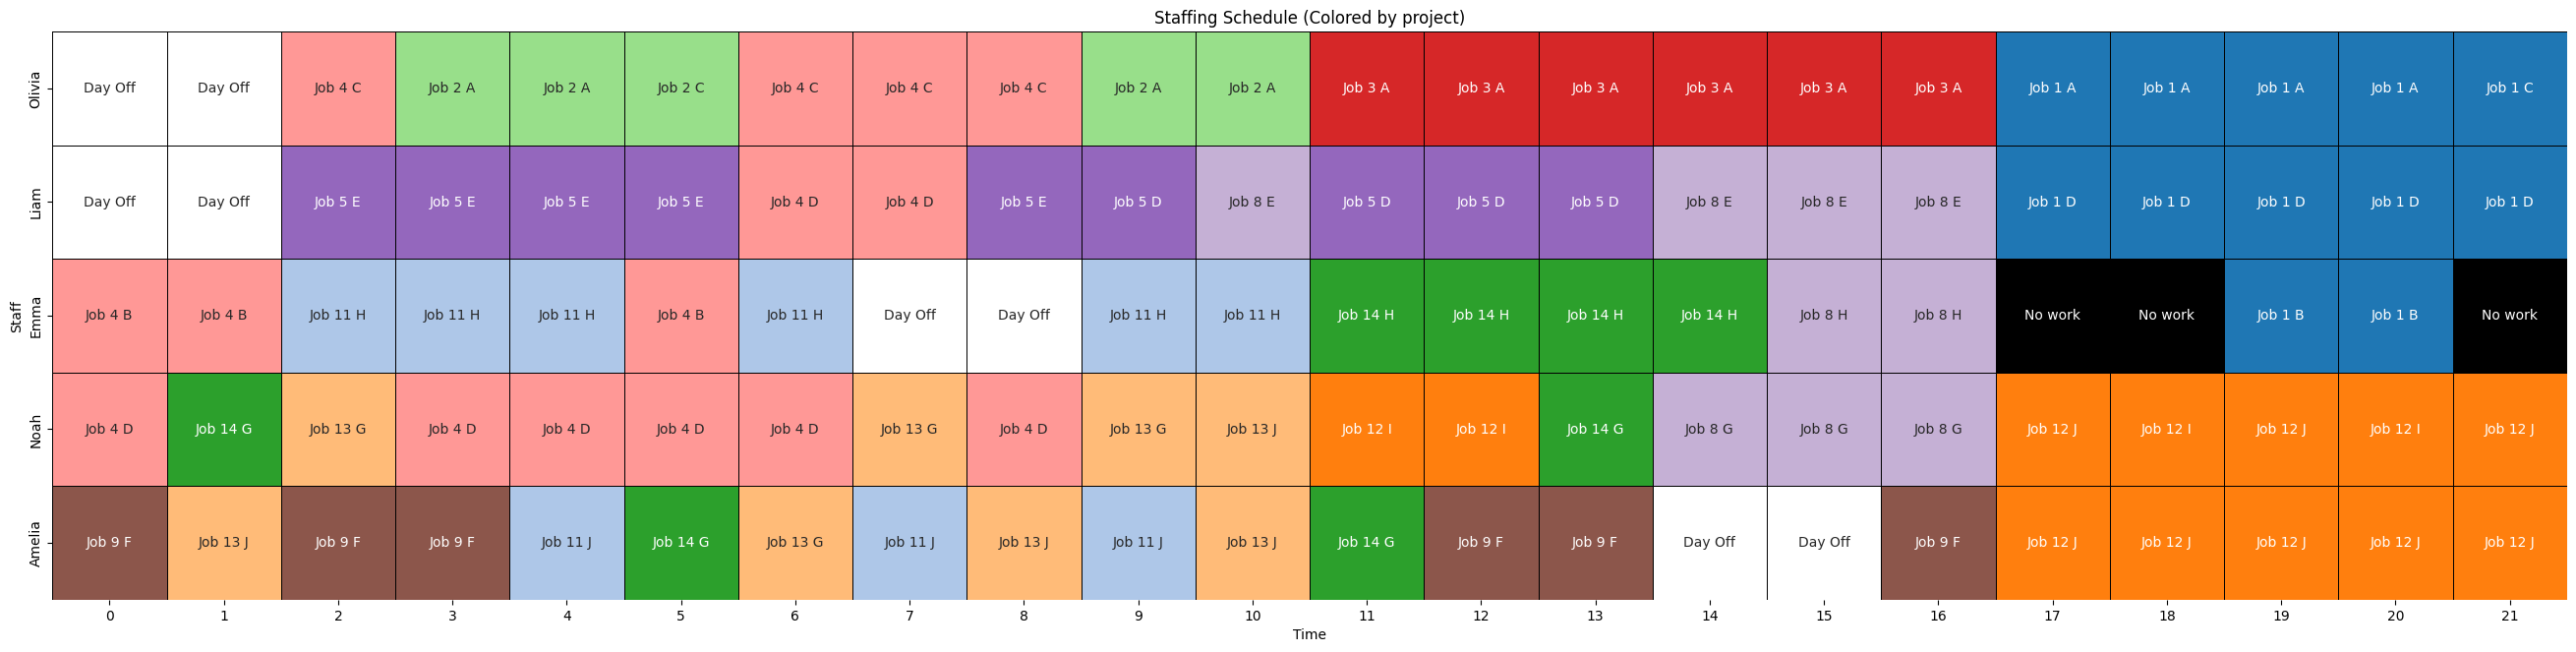

In [ ]:
# Extraire uniquement les projets pour le mapping couleur
def extract_project(val):
    if val in ["", "Day Off","No work"]:
        return val
    return val.split()[1]  # "Proj X" → "X"

project_table = table_plot.applymap(extract_project)

# Liste des projets uniques (hors "Day Off" et "No work assigned")
unique_projects = sorted(list(set(v for v in project_table.values.flatten() if v not in ["", "Day Off", "No work"])))

# Mapping projet → entier pour heatmap
project_to_int = {"Day Off": 0, "No work": 1}
project_to_int.update({v: i+2 for i, v in enumerate(unique_projects)})

int_table = project_table.replace(project_to_int).astype(int)

# Palette : blanc pour "Day Off", rouge pour "No work", puis couleurs pour projets
palette = [(1,1,1), (0,0,0)] + sns.color_palette("tab20", len(unique_projects))

# Plot
plt.figure(figsize=(h*1.5, staff_nb*1.5))
ax = sns.heatmap(int_table, annot=table_plot.values, fmt='',
                 cmap=palette,
                 cbar=False,
                 linewidths=0.5, linecolor='black')
        
ax.set_xlabel("Time")
ax.set_ylabel("Staff")
ax.set_title("Staffing Schedule (Colored by project)")
plt.show()